# variational.ipynb
A variational autoenconder writing the loss function from Eq. (7) in   
[Doersch 2016, Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)


-Sergio Verduzco  
June 2023



### Some resources I consulted:
https://youtu.be/uaaqyVS9-rM  
https://www.youtube.com/watch?v=YV9D3TWY5Zo  
https://www.youtube.com/watch?v=8wrLjnQ7EWQ  
https://www.youtube.com/watch?v=VELQT1-hILo  
https://github.com/karpathy/examples/blob/master/vae/main.py  
https://arxiv.org/pdf/1906.02691.pdf

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
lt.monkey_patch()

In [2]:
# Preliminary parameters
data_dir = '/home/z/Downloads/data/'  
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")
batch_size = 64
dataset = 'MNIST'  # MNIST. CIFAR10 not implemented yet.

device = cuda:0


Tricky things with the cell above:
* Batch size


Tricky things with the cell below:
* Which normalization value to use?
  * Must ensure it is consistent with the output nonlinearity of the decoder
  * Turns out `ToTensor` sets the values between 0 and 1, and this is enough. Further normalizing may hurt performance.

In [3]:
if dataset == 'CIFAR10':  # ignore!
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    #testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
elif dataset == 'MNIST':
    transform = transforms.Compose(
        [transforms.ToTensor(),
         #transforms.Normalize((1.), (0.5)),
         torch.squeeze])
    trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    #testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
else:
    raise ValueError("Specify a valid dataset")

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
# testloader = torch.utils.data.DataLoader(testset,
#                                          batch_size=batch_size,
#                                          shuffle=False,
#                                          num_workers=2)


2.0%

100.0%


Extracting /home/z/Downloads/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/z/Downloads/data/MNIST/raw


100.0%


Extracting /home/z/Downloads/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/z/Downloads/data/MNIST/raw




100.0%


Extracting /home/z/Downloads/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/z/Downloads/data/MNIST/raw



100.0%

Extracting /home/z/Downloads/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/z/Downloads/data/MNIST/raw



In [4]:
class FFP(nn.Module):
    """ A feedforward perceptron. """
    def __init__(self, sizes, nltypes, bias=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', or 'tanh'.
            bias: whether the layers have a bias unit
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(FFP, self).__init__()
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers):
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        return x

class normal_encoder(nn.Module):
    """ A FFP that outputs parameters for a multivariate normal distribution.
    
        This is the same as the FFP class, except that the output layer is
        duplicated by concatenating an extra set of units with sigmoidal 
        activation functions. This extra set of units corresponds to the
        entries of a diagonal covariance matrix, whereas the regular outputs
        corresponds to the means.
    """
    def __init__(self, sizes, nltypes, bias=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', 'tanh', or 'linear'.
            bias: whether the layers have a bias unit
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(normal_encoder, self).__init__()
        self.n_layers = len(nltypes)
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        # the last element in layers will be the sigmoidal variance layer
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers[:-1]):
            if lidx == self.n_layers - 1:
                y = nn.Sigmoid()(self.layers[-1](x))
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        return torch.concatenate((x, y), axis=-1)
        
class standard_SGD():
    """ An SGD optimizer for my FFP module. """
    def __init__(self, model, lr=0.1):
        """
            model: an instance of the FFP class
            lr: learning rate
        """
        self.model = model
        self.lr = lr
        
    def step(self):
        """ Updates the model's parameters. """
        for lidx, layer in enumerate(self.model.layers, 1):
            dw = self.lr * layer.weight.grad
            with torch.no_grad():
                layer.weight -= dw
                if self.model.bias:
                    layer.bias -= self.lr * layer.bias.grad
            
    def zero_grad(self):
        for layer in self.model.layers:
            layer.weight.grad.zero_()
            if self.model.bias:
                layer.bias.grad.zero_()

def KL_Loss(mu:torch.tensor, sigma:torch.tensor, reduction='mean') -> float:
    """ Encoder loss from the KL divergence.

        The loss is the KL divergence between two multivariate
        normals. The first has the given means, and a diagonal 
        variance matrix with the given sigma values. The second
        is a multivariate normal zero mean and identity covariance
        matrix.

        One term that is not relevant for the computation of gradients
        is removed from the loss (-k).
        
        Args:
            mu: mean values, size (m,k), where m=minibatch size, k=dimension
            sigma: variances, size (m,k)
                   All values must be positive.
            reduction: 'mean', 'sum', or None
        Returns:
            loss: KL divergence
    """
    loss =  0.5 * (sigma.sum(axis=1) + (mu * mu).sum(axis=1) - sigma.prod(axis=1).log())
    
    if loss.dim() == 0:
        return loss
    if reduction == 'mean':
        return loss.mean()
    if reduction == 'sum':
        return loss.sum()
    if reduction == None:
        return loss
    raise ValueError("type of reduction was not understood.")

def distro_loss(mu:torch.tensor, sigma:torch.tensor, reduction='mean') -> float:
    """ A MSE loss on the paramters of the multivariate normal.
    
    Args:
            mu: mean values, size (m,k), where m=minibatch size, k=dimension
            sigma: variances, size (m,k)
                   All values must be positive.
            reduction: 'mean', 'sum', or None
        Returns:
            norm of mu plus norm of (sigma - 1)
    """
    loss = (mu * mu).sum() + (sigma - 1).pow(2)

    if loss.dim() == 0:
        return loss
    if reduction == 'mean':
        return loss.mean()
    if reduction == 'sum':
        return loss.sum()
    if reduction == None:
        return loss
    raise ValueError("type of reduction was not understood.")

mse_loss = nn.MSELoss(reduction='mean')

Things that caused trouble with the cell above:
* Handling the separation in the last encoder layer. Half the outputs are mu, half are sigma.
* Ensuring that the sigma values of the encoder are always positive, and finding the right nonlinearity to use for the mu values.
  * The answer is to use sigmoidal activation for sigma, and a linear layer for mu.


Things that caused trouble with the cell below:
* Size of the network and type of nonlinearity for each layer.
  * Last layer of encoder must be able to produce both positive and negative values for mu, but only positive for sigma.
  * One video said the last layer of the decoder should use sigmoid units because of the MNIST image encoding. When I was normalizing the input images, nothing worked for me until I used a linear output layer. After I stoped normalizing a sigmoidal was probably better.
* Optimizer and learning rate

In [5]:
# create the encoder and decoder
enc_sizes = [784, 200, 100, 2]  # 20 means, 20 stds
enc_types = ['tanh', 'relu', 'linear']
encoder = normal_encoder(enc_sizes, enc_types, bias=True).to(device)

dec_sizes = [2, 100, 200, 784]
dec_types = ['tanh', 'relu', 'linear']
decoder = FFP(dec_sizes, dec_types, bias=True).to(device)

# Multivariate normal
assert enc_sizes[-1] == dec_sizes[0], "Check bottleneck sizes"
n_latent = dec_sizes[0]
std_multi_normal = torch.distributions.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent))

# Optimizers
# encoder_optim = standard_SGD(encoder, lr=0.001)
# decoder_optim = standard_SGD(decoder, lr=0.001)
encoder_optim = torch.optim.Adam(encoder.parameters(), lr=5e-4)
decoder_optim = torch.optim.Adam(decoder.parameters(), lr=5e-4)
# encoder_optim = torch.optim.SGD(encoder.parameters(), lr=0.1)
# decoder_optim = torch.optim.SGD(decoder.parameters(), lr=0.1)


In [6]:
# training loop
n_epochs = 10
bsize = trainloader.batch_size
w_bit = .1 / (n_epochs * (len(trainset) / bsize))
w = 0.001
for epoch in range(n_epochs):
    accum_latent_error = 0.
    accum_output_error = 0.
    print("----------------------------------------")
    for i, data in enumerate(trainloader):
        # retrieve the input
        input = data[0].flatten(start_dim=1).to(device)  # (bsize, 784)
        # feed the input to the encoder
        latent = encoder(input)  # (bsize, 2*n_latent)
        # extract means and diagonal of variance matrix
        means = latent[:, :enc_sizes[-1]]  # (bsize, n_latent)
        vars = latent[:, enc_sizes[-1]:]  # (bsize, n_latent)
        # sample from the multivariate normal. Size = (bsize, n_latent)
        #epsilons = std_multi_normal.sample((bsize,)).to(device)
        epsilons = torch.randn_like(vars)
        z = means + epsilons * vars
        # feed the sample to the decoder
        output = decoder(z)
        # Gradient descent
        # w += w_bit
        latent_error = w * KL_Loss(means, vars)
        # latent_error = w * distro_loss(means, vars)
        output_error = mse_loss(input, output)
        #output_error = F.binary_cross_entropy(input, output, reduction='mean')
        error = latent_error + output_error
        
        error.backward()
        
        encoder_optim.step()
        decoder_optim.step()

        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        with torch.no_grad():
            w += 1e-5 * (output_error - latent_error)

        # display error
        accum_latent_error += latent_error
        accum_output_error += output_error
        if (i+1) % 200 == 0:
            print(f"    latent error = {accum_latent_error/i} up to example {i*bsize}")
            print(f"    reconstruction error = {accum_output_error/i} up to example {i*bsize}")
    accum_latent_error /= len(trainloader)
    accum_output_error /= len(trainloader)
    print(f"latent error = {accum_latent_error} in epoch {epoch}")
    print(f"reconstruction error = {accum_output_error} in epoch {epoch}")
    print(f"w = {w}")

----------------------------------------
    latent error = 0.002696152776479721 up to example 12736
    reconstruction error = 0.0625157281756401 up to example 12736
    latent error = 0.00296276668086648 up to example 25536
    reconstruction error = 0.05762692540884018 up to example 25536
    latent error = 0.003186021000146866 up to example 38336
    reconstruction error = 0.055440112948417664 up to example 38336
    latent error = 0.003396489890292287 up to example 51136
    reconstruction error = 0.054002854973077774 up to example 51136
latent error = 0.0035270522348582745 in epoch 0
reconstruction error = 0.05316968634724617 in epoch 0
w = 0.0014656480634585023
----------------------------------------
    latent error = 0.00459688063710928 up to example 12736
    reconstruction error = 0.04819637909531593 up to example 12736
    latent error = 0.004724289756268263 up to example 25536
    reconstruction error = 0.04786524921655655 up to example 25536
    latent error = 0.00485497

In [7]:
class image_generator():
    def __init__(self, decoder, distribution):
        self.decoder = decoder
        self.distribution = distribution

    def generate(self, show=True):
        input = self.distribution.sample().to(device)
        
        output = decoder(input).reshape((28,28)).to('cpu').detach()
        if show:
            plt.imshow(output)
        return output

# empirical_multi_normal = torch.distributions.MultivariateNormal(0.0*torch.ones(n_latent), 0.7*torch.eye(n_latent))
# imgen = image_generator(decoder, empirical_multi_normal)

imgen = image_generator(decoder, std_multi_normal)

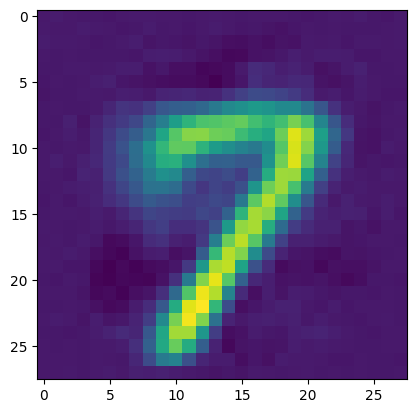

In [28]:
# run repeatedly to get many images
val = imgen.generate()

In [29]:
# Test the decoder's statistitics. Should look like the "input" next cell
print(val)
#print(std_multi_normal.sample())

tensor[28, 28] n=784 (3.1Kb) x∈[-0.073, 1.001] μ=0.123 σ=0.242


In [30]:
# Test the encoder's output statistics
sample_num = 5

for n in range(sample_num):
    input = trainset[n][0].flatten().reshape(1,-1).to(device)
    latent = encoder(input)
    mu = latent[0, :n_latent]
    sigma = latent[0, n_latent:]
    print("input = ", end=" ")
    print(input)
    print("mu = ", end=" ")
    print(mu)
    print("sigma = ", end=" ")
    print(sigma)
    print("==========================")

input =  tensor[1, 784] 3.1Kb x∈[0., 1.000] μ=0.138 σ=0.313 cuda:0
mu =  tensor[2] μ=-0.709 σ=0.151 grad SliceBackward0 cuda:0 [-0.602, -0.816]
sigma =  tensor[2] μ=0.138 σ=0.041 grad SliceBackward0 cuda:0 [0.109, 0.167]
input =  tensor[1, 784] 3.1Kb x∈[0., 1.000] μ=0.156 σ=0.329 cuda:0
mu =  tensor[2] μ=0.813 σ=0.997 grad SliceBackward0 cuda:0 [1.518, 0.108]
sigma =  tensor[2] μ=0.112 σ=0.026 grad SliceBackward0 cuda:0 [0.093, 0.131]
input =  tensor[1, 784] 3.1Kb x∈[0., 1.000] μ=0.097 σ=0.257 cuda:0
mu =  tensor[2] μ=-0.096 σ=0.426 grad SliceBackward0 cuda:0 [0.205, -0.397]
sigma =  tensor[2] μ=0.084 σ=0.024 grad SliceBackward0 cuda:0 [0.067, 0.101]
input =  tensor[1, 784] 3.1Kb x∈[0., 1.000] μ=0.086 σ=0.259 cuda:0
mu =  tensor[2] μ=-0.820 σ=1.292 grad SliceBackward0 cuda:0 [-1.734, 0.094]
sigma =  tensor[2] μ=0.155 σ=0.004 grad SliceBackward0 cuda:0 [0.158, 0.153]
input =  tensor[1, 784] 3.1Kb x∈[0., 1.000] μ=0.116 σ=0.292 cuda:0
mu =  tensor[2] μ=0.219 σ=0.422 grad SliceBackward0 cu

In [71]:
torch.save(decoder.state_dict(), 'decoder_distro_loss01.pth')